The following example shows how to use TransBigData to process bus GPS data, including identifying bus arrival and departure information, calculate travel time and operating speed for buses.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import transbigdata as tbd
import pandas as pd
import geopandas as gpd

# Read data

## Read bus GPS data

In [3]:
BUS_GPS= pd.read_csv(r'data/busgps.csv',header = None)
BUS_GPS.columns = ['GPSDateTime', 'LineId', 'LineName', 'NextLevel', 'PrevLevel',
       'Strlatlon', 'ToDir', 'VehicleId', 'VehicleNo', 'unknow']
#Convert the time column to datetime type
BUS_GPS['GPSDateTime'] = pd.to_datetime(BUS_GPS['GPSDateTime'])

Convert coordinates

In [4]:
#Slice the latitude and longitude string
BUS_GPS['lon'] = BUS_GPS['Strlatlon'].apply(lambda r:r.split(',')[0])
BUS_GPS['lat'] = BUS_GPS['Strlatlon'].apply(lambda r:r.split(',')[1])
#Convert coordinates
BUS_GPS['lon'],BUS_GPS['lat'] = tbd.gcj02towgs84(BUS_GPS['lon'].astype(float),BUS_GPS['lat'].astype(float))
BUS_GPS.head(5)

,GPSDateTime,LineId,LineName,NextLevel,PrevLevel,Strlatlon,ToDir,VehicleId,VehicleNo,unknow,lon,lat
0,2019-01-16 23:59:59,7100,71,2,1,"121.335413,31.173188",1,沪D-R7103,Z5A-0021,1,121.330858,31.175129
1,2019-01-17 00:00:00,7100,71,2,1,"121.334616,31.172271",1,沪D-R1273,Z5A-0002,1,121.330063,31.174214
2,2019-01-17 00:00:00,7100,71,24,23,"121.339955,31.173025",0,沪D-R5257,Z5A-0020,1,121.335390,31.174958
3,2019-01-17 00:00:01,7100,71,14,13,"121.409491,31.20433",0,沪D-R5192,Z5A-0013,1,121.404843,31.206179
4,2019-01-17 00:00:03,7100,71,15,14,"121.398615,31.200253",0,沪D-T0951,Z5A-0022,1,121.393966,31.202103


## Read the bus line data

<AxesSubplot:>

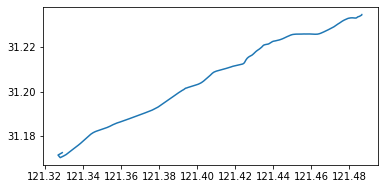

In [5]:
shp = r'data/busline.json'
linegdf = gpd.GeoDataFrame.from_file(shp,encoding = 'gbk')
line = linegdf.iloc[:1].copy()
line.plot()

## Read the bus stop data



<AxesSubplot:>

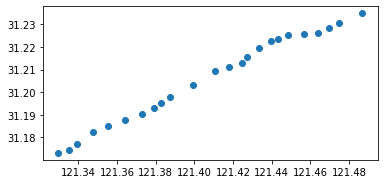

In [6]:
shp = r'data/busstop.json'
stop = gpd.GeoDataFrame.from_file(shp,encoding = 'gbk')
stop = stop[stop['linename'] == '71路(延安东路外滩-申昆路枢纽站)']
stop.plot()

# Identifying arrival and departure information

In [7]:
arriveinfo = tbd.busgps_arriveinfo(BUS_GPS,line,stop)

Cleaning data...
Position matching......
Matching arrival and leaving info.........................................................................................................................................................

In [8]:
arriveinfo

,arrivetime,leavetime,stopname,VehicleId
0,2019-01-17 07:19:42,2019-01-17 07:31:14,延安东路外滩,1
1,2019-01-17 09:53:08,2019-01-17 10:09:34,延安东路外滩,1
0,2019-01-17 07:13:23,2019-01-17 07:15:45,西藏中路,1
1,2019-01-17 07:34:24,2019-01-17 07:35:38,西藏中路,1
2,2019-01-17 09:47:03,2019-01-17 09:50:22,西藏中路,1
...,...,...,...,...
2,2019-01-17 16:35:52,2019-01-17 16:36:49,吴宝路,148
3,2019-01-17 19:21:09,2019-01-17 19:23:44,吴宝路,148
0,2019-01-17 13:36:26,2019-01-17 13:45:04,申昆路枢纽站,148
1,2019-01-17 15:52:26,2019-01-17 16:32:46,申昆路枢纽站,148


# One-way travel time

Calculate the One-way travel time from ``arriveinfo`` obtained above. Given start and end stop name of the bus line, ``tbd.busgps_onewaytime`` can calculate the travel time between the two station.

In [20]:
onewaytime = tbd.busgps_onewaytime(arriveinfo,
                                   start = '延安东路外滩',
                                   end = '申昆路枢纽站',col = ['VehicleId','stopname', 'arrivetime', 'leavetime'])

In [15]:
onewaytime

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction
0,2019-01-17 07:31:14,延安东路外滩,1,2019-01-17 08:24:42,申昆路枢纽站,1.0,3208.0,7,延安东路外滩-申昆路枢纽站
1,2019-01-17 10:09:34,延安东路外滩,1,2019-01-17 11:03:49,申昆路枢纽站,1.0,3255.0,10,延安东路外滩-申昆路枢纽站
0,2019-01-17 13:11:43,延安东路外滩,2,2019-01-17 14:05:17,申昆路枢纽站,2.0,3214.0,13,延安东路外滩-申昆路枢纽站
1,2019-01-17 15:42:28,延安东路外滩,2,2019-01-17 16:37:00,申昆路枢纽站,2.0,3272.0,15,延安东路外滩-申昆路枢纽站
0,2019-01-17 18:46:11,延安东路外滩,3,2019-01-17 19:51:54,申昆路枢纽站,3.0,3943.0,18,延安东路外滩-申昆路枢纽站
...,...,...,...,...,...,...,...,...,...
1,2019-01-17 17:11:43,申昆路枢纽站,144,2019-01-17 18:13:22,延安东路外滩,144.0,3699.0,17,申昆路枢纽站-延安东路外滩
0,2019-01-17 08:15:44,申昆路枢纽站,147,2019-01-17 09:14:46,延安东路外滩,147.0,3542.0,8,申昆路枢纽站-延安东路外滩
1,2019-01-17 10:51:34,申昆路枢纽站,147,2019-01-17 11:50:03,延安东路外滩,147.0,3509.0,10,申昆路枢纽站-延安东路外滩
0,2019-01-17 13:45:04,申昆路枢纽站,148,2019-01-17 14:44:03,延安东路外滩,148.0,3539.0,13,申昆路枢纽站-延安东路外滩


For English display of the figures, here we will change the station name and direction name into English:

In [21]:
onewaytime.loc[onewaytime['stopname']=='延安东路外滩','stopname']="Yanan road station"
onewaytime.loc[onewaytime['stopname1']=='申昆路枢纽站','stopname1']="Shenkun station"
onewaytime.loc[onewaytime['direction']=='延安东路外滩-申昆路枢纽站','direction']="Yanan road-Shenkun"
onewaytime.loc[onewaytime['direction']=='申昆路枢纽站-延安东路外滩','direction']="Shenkun-Yanan road"

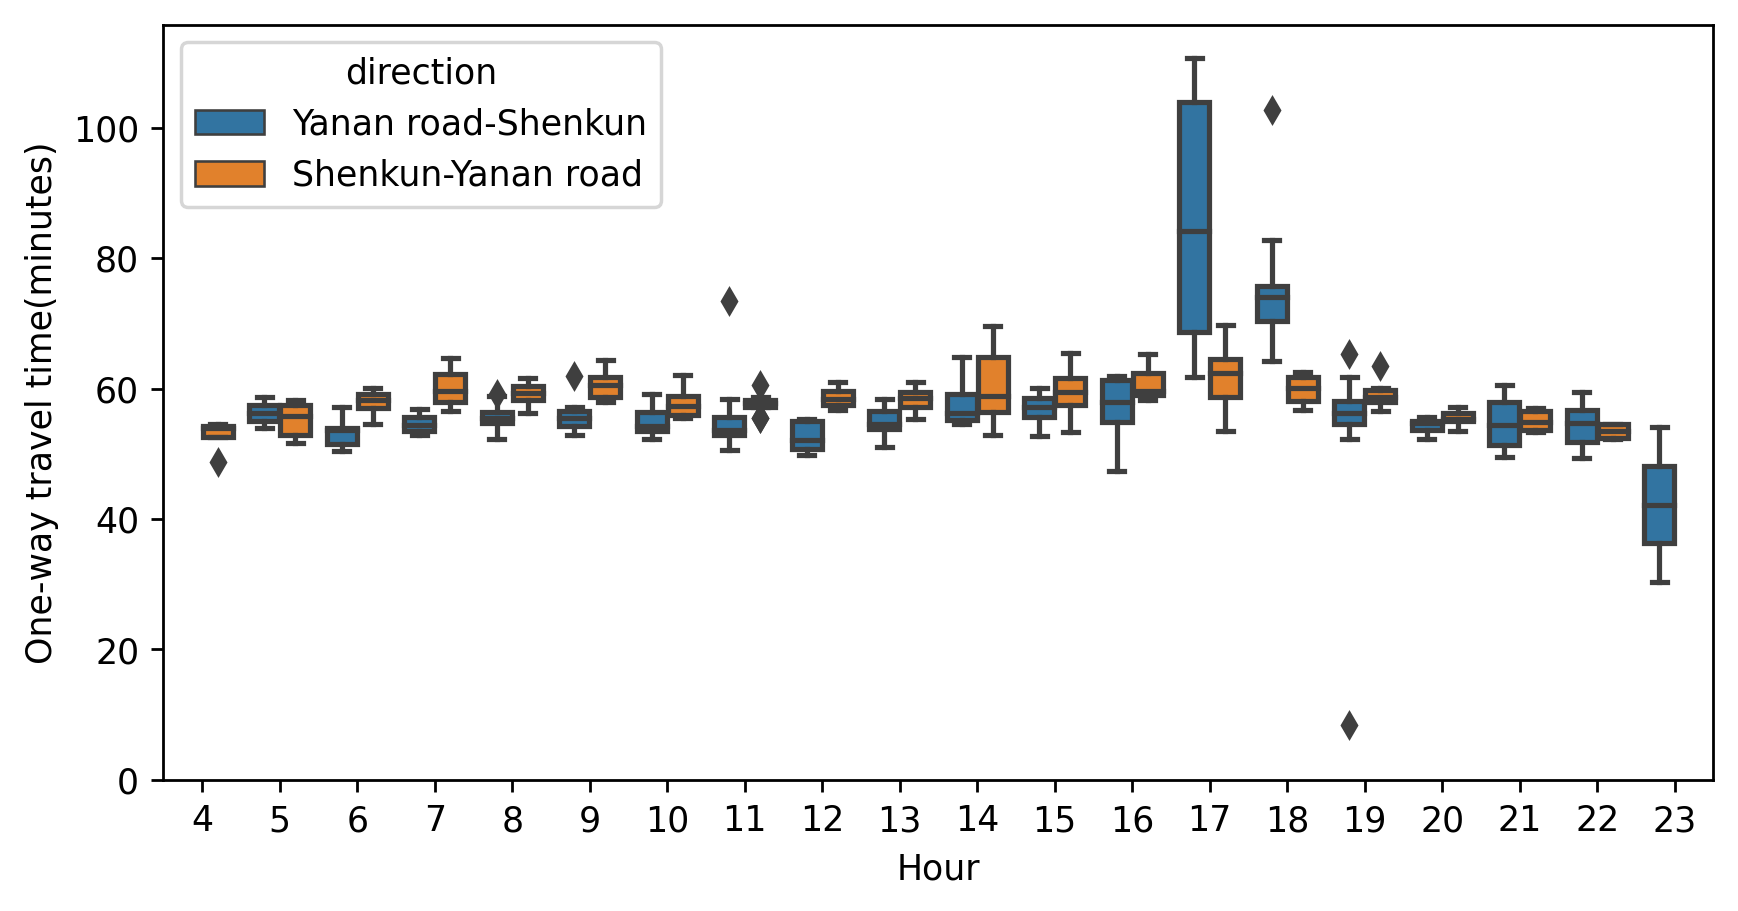

In [23]:
## Draw box plot for one-way travel time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
fig     = plt.figure(1,(8,4),dpi = 250)
ax1      = plt.subplot(111)

sns.boxplot(x = 'shour',y = onewaytime['duration']/60,hue = 'direction',data = onewaytime)

plt.ylabel('One-way travel time(minutes)')
plt.xlabel('Hour')
plt.ylim(0)
plt.show()

# Travel speed of the buses

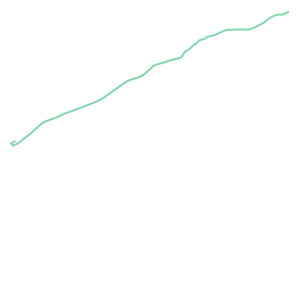

In [24]:
#Convert coordinate system to projection coordinate system for later calculation of distance
line.crs = {'init':'epsg:4326'}
line_2416 = line.to_crs(epsg = 2416)
#Obtain the geometry inside the bus route data
lineshp = line_2416['geometry'].iloc[0]
linename = line_2416['name'].iloc[0]
lineshp


In [25]:
#Remove the data with abnormal speed
#Vehicle speed units converted to km/h
onewaytime['speed'] = (lineshp.length/onewaytime['duration'])*3.6
onewaytime = onewaytime[onewaytime['speed']<=60]

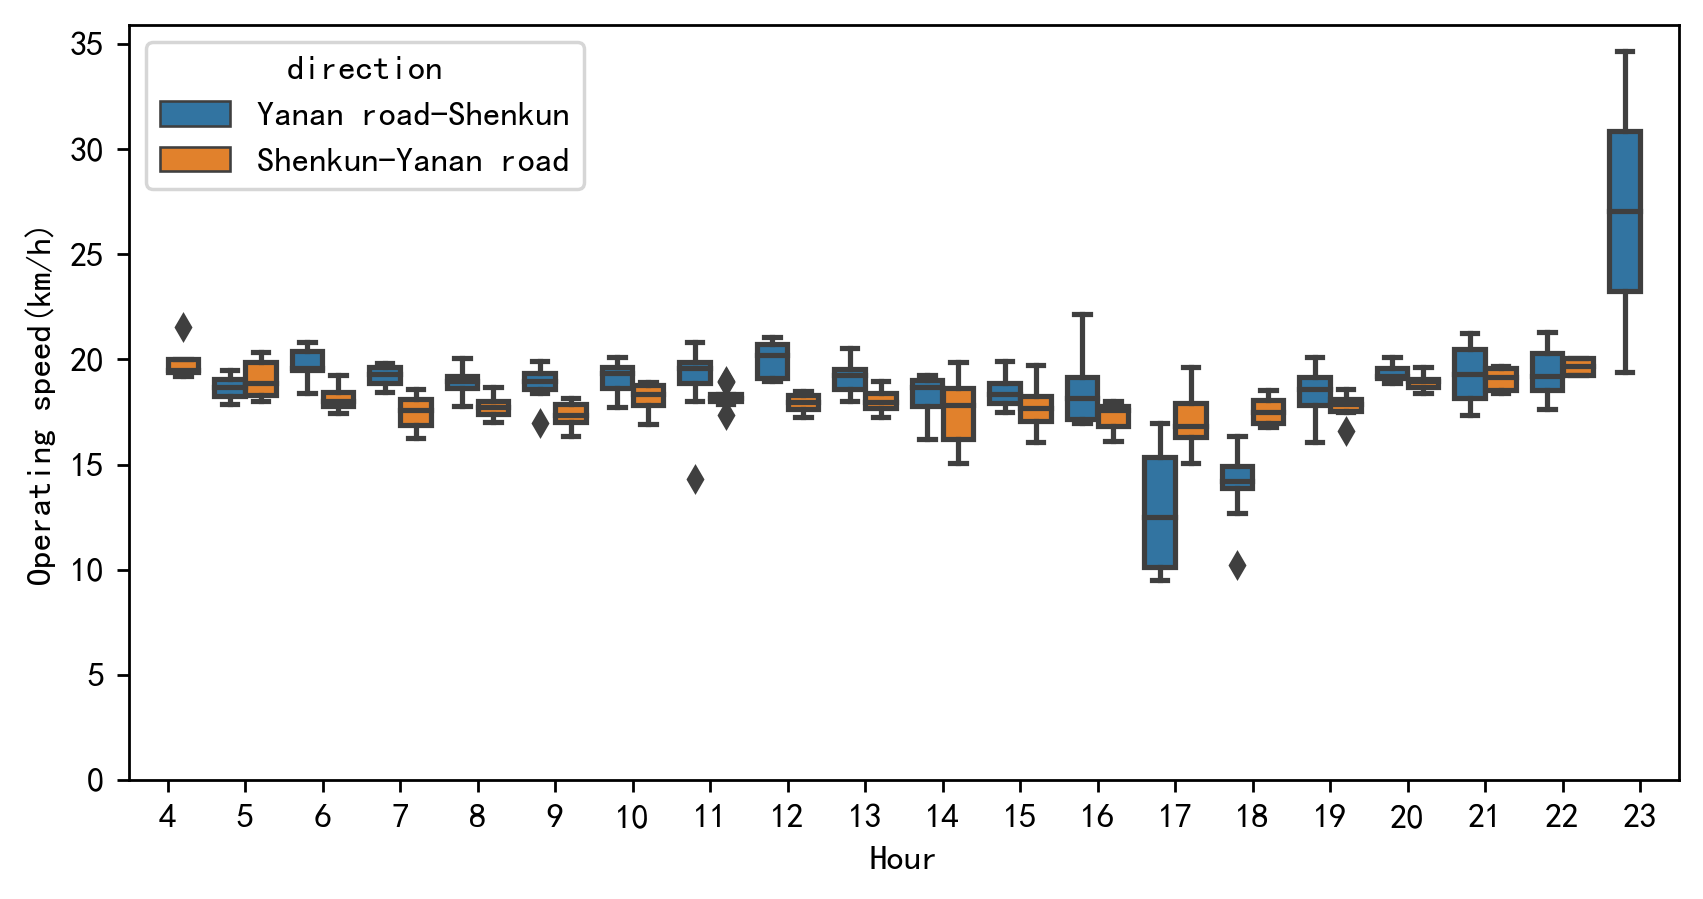

In [26]:
## Travel speed distribution
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig     = plt.figure(1,(8,4),dpi = 250)
ax1      = plt.subplot(111)
sns.boxplot(x = 'shour',y = 'speed',hue = 'direction',data = onewaytime)
plt.ylabel('Operating speed(km/h)')
plt.xlabel('Hour')
plt.ylim(0)
plt.show()